# Fully Connected neural Networks

### Benötigte imports

In [1]:
import keras as keras
import numpy as np
import tensorflow as tf
import os

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D
from tensorflow.python.eager import context
from tensorflow.keras.utils import plot_model
from keras.models import clone_model
from keras.optimizers import Adam, SGD
import matplotlib.ticker as ticker

import matplotlib.pyplot as plt
import random

2024-06-10 17:01:25.730002: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Digit Recognition

### Erstellung des Modells

In [2]:
# initialisierung des Modells
untrained_model = Sequential()
untrained_model.add(Dense(600, activation='relu', input_shape=(784, ),name = "first_layer"))
untrained_model.add(Dense(400, activation='relu',  name = "hidden_layer_1"))
untrained_model.add(Dense(100, activation='relu',  name = "hidden_layer_2"))
untrained_model.add(Dense(10, activation = 'softmax', name = "output_layer"))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Erstelltes Modell kompilieren

In [3]:
# kompilieren des Modells
model = clone_model(untrained_model)


optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### Einlesen der Trainingsdaten

In [4]:
import random
from keras.datasets import mnist
import sys

# Diese Methode ließt eine Anzahl von train_size Handgeschriebenen Ziffern zum Training und eine Anzahl von
# test_size Hangeschriebenen Ziffern zum Testen aus dem  mnist dataset in arrays und gibt die arrays zurück
import inspect
print(inspect.getsource(mnist.load_data))
def readData(train_size, test_size):
    # Lade den MNIST-Datensatz
    data=np.load("mnist.npz")
    x_train=data['x_train']
    y_train=data['y_train']
    x_test=data['x_test']
    y_test=data['y_test']
    #(x_train, y_train), (x_test, y_test) = mnist.load_data()
    
    # Überprüfe, ob train_size oder test_size nicht größer als die Anzahl der Datensätze ist
    if train_size > len(x_train) :
        print("Fehler: train_size überschreitet Datenmenge von "+str(len(x_train)))
        sys.exit() 
    if test_size > len(x_test) :
        print("Fehler: test_size überschreitet Datenmenge von "+str(len(x_test)))
        sys.exit() 

    # Wähle zufällige Indizes für Trainingsdaten
    train_indices = random.sample(range(len(x_train)), train_size)
    # Wähle zufällige Indizes für Testdaten
    test_indices = random.sample(range(len(x_test)), test_size)
    
    # Extrahiere die ausgewählten Trainingsdaten und Testdaten
    train_data = x_train[train_indices].reshape(train_size, -1) / 255.0
    verify_train_data = y_train[train_indices]
    test_data = x_test[test_indices].reshape(test_size, -1) / 255.0
    verify_test_data = y_test[test_indices]

    return train_data, verify_train_data, test_data, verify_test_data

@keras_export("keras.datasets.mnist.load_data")
def load_data(path="mnist.npz"):
    """Loads the MNIST dataset.

    This is a dataset of 60,000 28x28 grayscale images of the 10 digits,
    along with a test set of 10,000 images.
    More info can be found at the
    [MNIST homepage](http://yann.lecun.com/exdb/mnist/).

    Args:
        path: path where to cache the dataset locally
            (relative to `~/.keras/datasets`).

    Returns:
        Tuple of NumPy arrays: `(x_train, y_train), (x_test, y_test)`.

    **`x_train`**: `uint8` NumPy array of grayscale image data with shapes
      `(60000, 28, 28)`, containing the training data. Pixel values range
      from 0 to 255.

    **`y_train`**: `uint8` NumPy array of digit labels (integers in range 0-9)
      with shape `(60000,)` for the training data.

    **`x_test`**: `uint8` NumPy array of grayscale image data with shapes
      `(10000, 28, 28)`, containing the test data. Pixel values range
      from 0 to 255.

    **`y_tes

In [5]:
# importiere callback Klasse um benutzerdefinierte Aktionen während des Trainings des Modells durchführen zu können
from keras.callbacks import Callback

# erstelle Klasse mit benutzerdefinierten Aktionen, die während des trainings ausgeführt werden sollen
class TrainMetricsCallback(Callback):
    def __init__(self, x_test=None, y_test=None):
        super(TrainMetricsCallback, self).__init__()
        # listen zum speichern der accuracy und losses auf dem Test und dem Trainingsdatenset nach jeder epoch
        self.train_losses = []
        self.train_accuracies = []
        self.test_losses = []
        self.test_accuracies = []
        self.x_test = x_test
        self.y_test = y_test

    # Am ende der epoch füge die accuracy und loss werte zu den Listen hinzu
    def on_epoch_end(self, epoch, logs=None):
        self.train_losses.append(logs.get('loss'))
        self.train_accuracies.append(logs.get('accuracy'))
        
        if self.x_test is not None and self.y_test is not None:
            # Auswerten der modells für das Trainigsdatenset
            loss, accuracy = self.model.evaluate(self.x_test, self.y_test, verbose=0)
            self.test_losses.append(loss)
            self.test_accuracies.append(accuracy)

# Methode um nach jdem Trainingsschritt die accuracy und loss sowohl auf dem Testdatenset als auch
# auf den Trainingsdatenset als Liste zurückzugeben
def train_and_get_metrics(model, x_train, y_train, x_test=None, y_test=None, epochs=1, batch_size = 128):
    train_metrics_callback = TrainMetricsCallback(x_test, y_test)
    model.fit(x_train, y_train, epochs=epochs, callbacks=[train_metrics_callback],  batch_size=batch_size)
    
    # geben die accuracies und losses für die Test und Trainingsdaten zurück
    return train_metrics_callback.train_losses, train_metrics_callback.train_accuracies, \
           train_metrics_callback.test_losses, train_metrics_callback.test_accuracies, model


In [6]:
# Einlesen der Trainingsdaten und Testdaten
train_length = 200
test_length = 10000
epoch=17
train_data, train_verification_data, test_data, test_verification_data = readData(train_length, test_length)

### Training des Modells

In [7]:
# Trainieren des Modells
train_losses, train_accuracies,test_losses, test_accuracies, model = train_and_get_metrics(model, train_data, train_verification_data, test_data, test_verification_data,  epochs=epoch, batch_size=128)

Epoch 1/17
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 486ms/step - accuracy: 0.0830 - loss: 2.3094
Epoch 2/17
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.6450 - loss: 1.8307
Epoch 3/17
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step - accuracy: 0.8579 - loss: 1.3641
Epoch 4/17
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step - accuracy: 0.9021 - loss: 0.8994
Epoch 5/17
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step - accuracy: 0.9121 - loss: 0.5737
Epoch 6/17
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step - accuracy: 0.9358 - loss: 0.3500
Epoch 7/17
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step - accuracy: 0.9570 - loss: 0.2208
Epoch 8/17
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step - accuracy: 0.9689 - loss: 0.1326
Epoch 9/17
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 474ms/step - accuracy: 0.9941 - loss: 0.0769
Epoch 10/17
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step - accuracy: 1.0000 - loss: 0.0480
Epoch 11/17
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step - accuracy: 1.0000 - loss: 0.0280
Epoch 12/17
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step - accuracy: 1.0000 - lo

### Testen und plotten

In [8]:
# Konvertiert das 1D-Array in ein 2D-Array, das zum Plotten der Ziffer verwendet wird.
def to2DArray(vektor):
    matrix = np.zeros((28,28))
    for i in range(28):
        for j in range(28):
            matrix[i, j] = vektor[i*28 + j]
            
    return matrix

def predictAndPlotAndShowOutput(modell, testdaten, test_verifikationsdaten, label=False):
    ziffern_verfügbar = range(len(testdaten))
    ziffern_zum_plotten = np.random.choice(ziffern_verfügbar, size = 6, replace=False)
    if label:
        fig, ax = plt.subplots(3, 4, figsize=(12, 12))
    else:
        fig, ax = plt.subplots(3, 4, figsize=(12, 9))
    for j in range(3):
        for i in range(2):
            vorhersage = modell.predict(np.array([testdaten[ziffern_zum_plotten[j*2+i]]]))
            geratene_ziffer = np.argmax(vorhersage)
            confidence = np.max(vorhersage)
            ax[j, 2*i].imshow(to2DArray(testdaten[ziffern_zum_plotten[j*2+i]]), cmap='gray', interpolation='none')
            #+ ", confidence: " +str(round(confidence,3)))
            ax[j, 2*i].axes.get_xaxis().set_visible(False)
            ax[j, 2*i].axes.get_yaxis().set_visible(False)
            ax[j, 2*i+1].bar(np.arange(10), vorhersage[0], color = 'navy')
            
            ax[j, 2*i+1].set_ylabel("Probability")
            ax[j, 2*i+1].set_ylim(0,1)
            ax[j, 2*i+1].set_title("Output")

            if label:
                ax[j, 2*i+1].set_xticks(np.arange(10))
                ax[j, 2*i+1].set_xticklabels(label,rotation = 75)
                ax[j, 2*i].set_title("Prediction: "+label[geratene_ziffer])
            else:
                ax[j, 2*i].set_title("Prediction: "+str(geratene_ziffer))
                ax[j, 2*i+1].set_xticks(np.arange(10))
                ax[j, 2*i+1].set_xlabel("Digit")
    if label:
        plt.subplots_adjust(hspace=0.4, wspace=0.3)

  
    plt.tight_layout()
    plt.savefig("output.png", dpi=500)
    
    plt.subplots_adjust(hspace=0.4, wspace = 0.3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


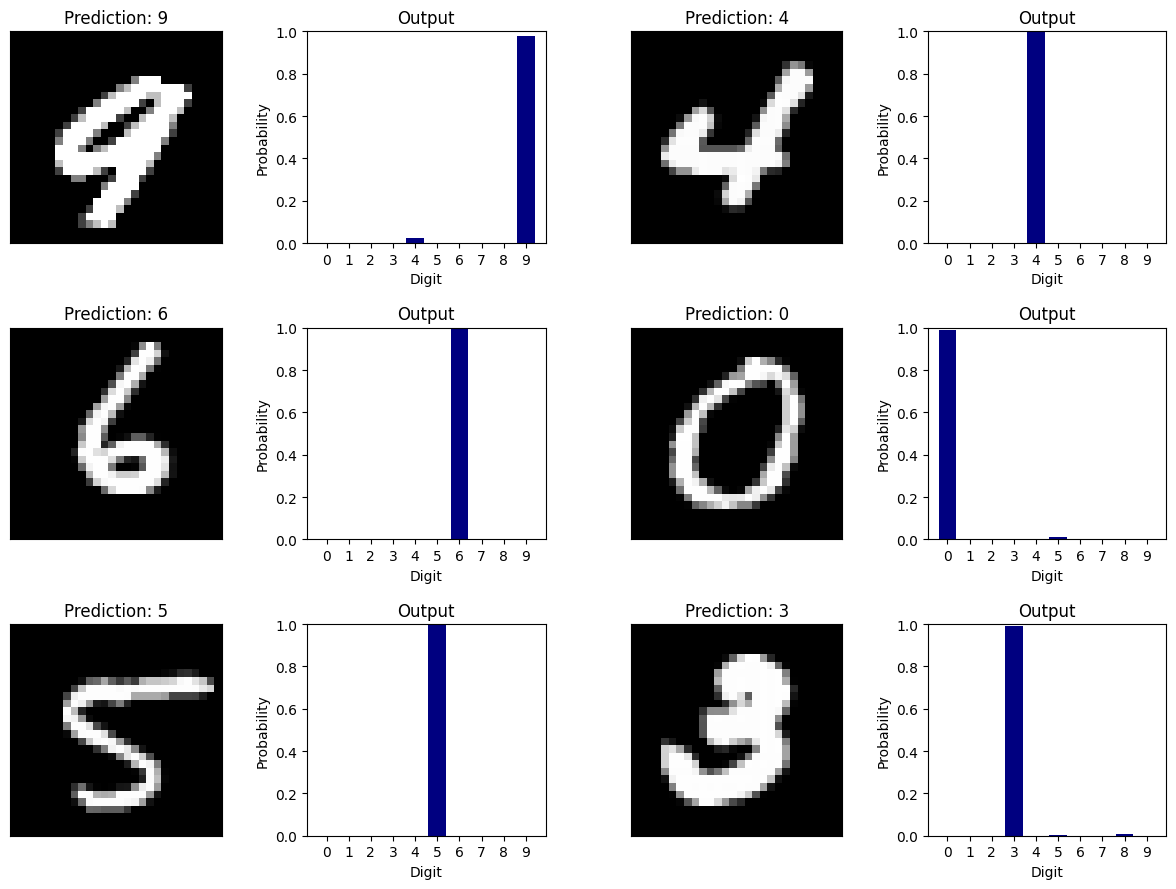

In [9]:
predictAndPlotAndShowOutput(model, test_data, test_verification_data)

### Trainingsverlauf

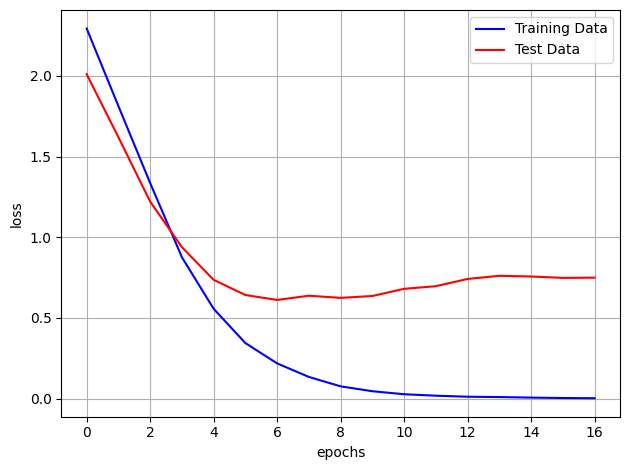

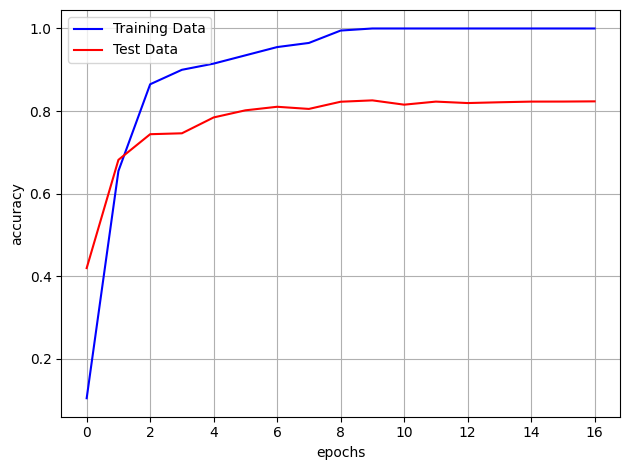

In [10]:
# plotten
epochs = np.arange(epoch)
plt.plot(epochs, train_losses, label = 'Training Data', color ='blue')
plt.plot(epochs, test_losses, label = 'Test Data', color ='red')
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(epochs, train_accuracies, label = 'Training Data', color ='blue')
plt.plot(epochs, test_accuracies, label = 'Test Data', color ='red')
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

## Fashion Recognition

### Daten Laden

In [11]:
def load_mnist(kind='train', model_type ='convolutional'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(os.getcwd(),
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(os.getcwd(),
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)
    if model_type == 'convolutional':
        with gzip.open(images_path, 'rb') as imgpath:
            images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                                offset=16).reshape(len(labels), 28, 28)#.reshape(len(labels), 784)
    elif model_type == 'fully_connected':
        with gzip.open(images_path, 'rb') as imgpath:
            images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

### Lade Fashion Daten

In [12]:
x_train_full_connected, y_train_full_connected = load_mnist(kind='train', model_type ='fully_connected')
x_test_full_connected, y_test_full_connected = load_mnist(kind='t10k', model_type ='fully_connected')
x_train_full_connected = np.expand_dims(x_train_full_connected, -1)
x_test_full_connected = np.expand_dims(x_test_full_connected, -1)

### Neues Modell erstellen (clonen) und trainieren

In [13]:
modelFullyConnected = clone_model(untrained_model)
optimizer = Adam(learning_rate=0.001)
modelFullyConnected.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
train_losses_fully_con, train_accuracies_fully_con, test_losses_fully_con, test_accuracies_fully_con, modelFullyConnected = train_and_get_metrics(modelFullyConnected, x_train_full_connected[:200], y_train_full_connected[:200], x_test_full_connected, y_test_full_connected,  epochs=17,  batch_size=128)

Epoch 1/17
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 522ms/step - accuracy: 0.1039 - loss: 188.7008
Epoch 2/17
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - accuracy: 0.1386 - loss: 159.3603
Epoch 3/17
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.4295 - loss: 79.4929
Epoch 4/17
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.4759 - loss: 35.8124
Epoch 5/17
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - accuracy: 0.5096 - loss: 22.1657
Epoch 6/17
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step - accuracy: 0.5705 - loss: 15.4300
Epoch 7/17
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - accuracy: 0.5649 - loss: 11.1717
Epoch 8/17
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 489ms/step - accuracy: 0.6283 - loss: 9.3057
Epoch 9/17
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.7752 - loss: 5.1096
Epoch 10/17
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.7719 - loss: 5.8439
Epoch 11/17
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - accuracy: 0.7800 - loss: 4.6866
Epoch 12/17
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - accuracy: 0.

### Teste und plotte

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


/var/folders/22/p3t1mllj1gg156gy7k3fzpnh0000gn/T/ipykernel_36743/2488668663.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  matrix[i, j] = vektor[i*28 + j]
/var/folders/22/p3t1mllj1gg156gy7k3fzpnh0000gn/T/ipykernel_36743/2488668663.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  matrix[i, j] = vektor[i*28 + j]
/var/folders/22/p3t1mllj1gg156gy7k3fzpnh0000gn/T/ipykernel_36743/2488668663.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  matrix[i, j] = vektor

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


/var/folders/22/p3t1mllj1gg156gy7k3fzpnh0000gn/T/ipykernel_36743/2488668663.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  matrix[i, j] = vektor[i*28 + j]
/var/folders/22/p3t1mllj1gg156gy7k3fzpnh0000gn/T/ipykernel_36743/2488668663.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  matrix[i, j] = vektor[i*28 + j]


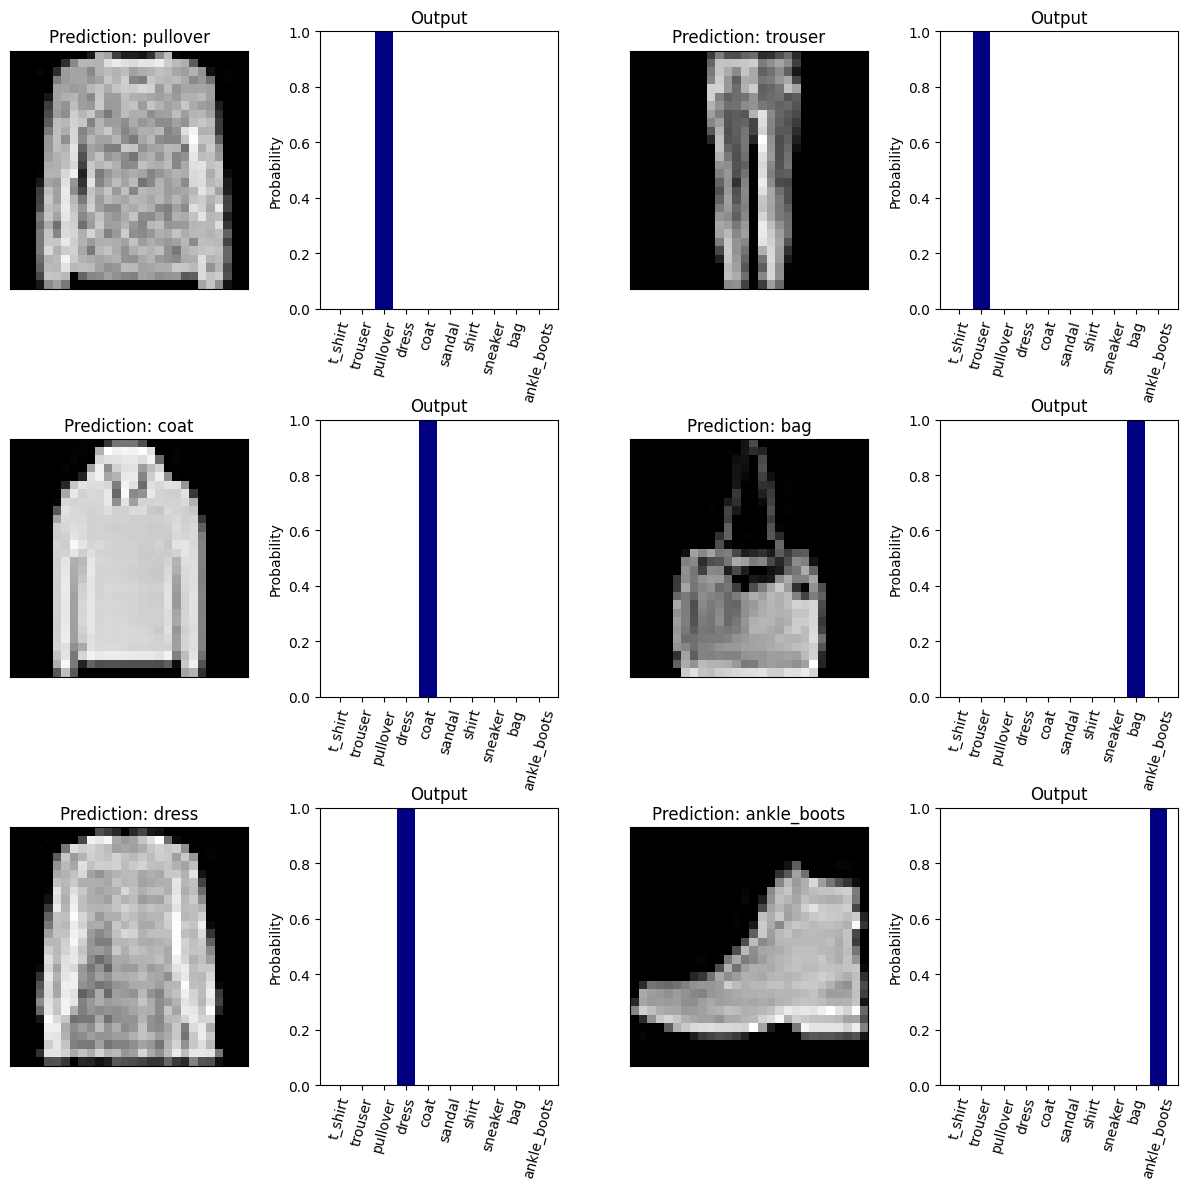

In [14]:
LABEL_NAMES = ['t_shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle_boots']
predictAndPlotAndShowOutput(modelFullyConnected, x_test_full_connected, y_test_full_connected, LABEL_NAMES)

### Trainingsverlauf

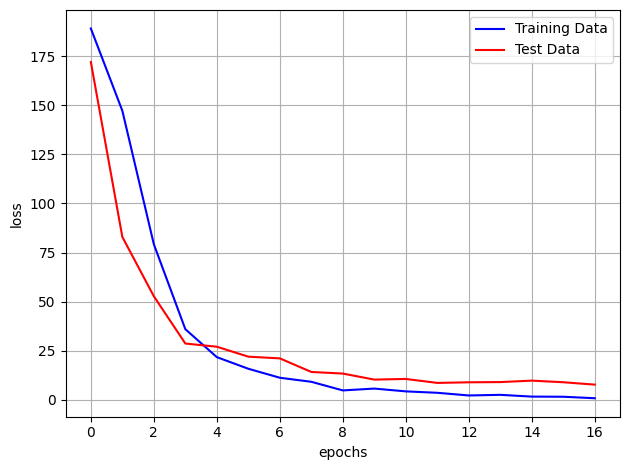

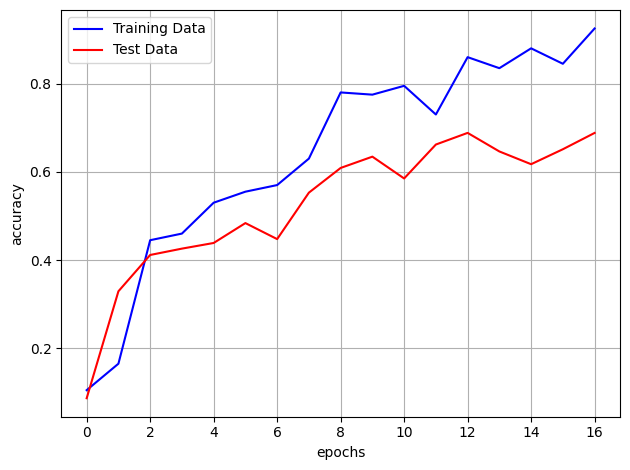

In [15]:
# plotten
epochs = np.arange(epoch)
plt.plot(epochs, train_losses_fully_con, label = 'Training Data', color ='blue')
plt.plot(epochs, test_losses_fully_con, label = 'Test Data', color ='red')
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(epochs, train_accuracies_fully_con, label = 'Training Data', color ='blue')
plt.plot(epochs, test_accuracies_fully_con, label = 'Test Data', color ='red')
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Convolutional Neural Networks

### Imports

In [16]:
#benötigte imports
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from keras.callbacks import Callback
import tensorflow as tf
from tensorflow.python.eager import context
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import random
import gzip
import os
import numpy as np
from keras.optimizers import Adam, SGD
import sys



### multithreading Einstellungen

In [17]:
# parallelization Einstellungen
_ = tf.Variable([1])
context._context = None
context._create_context()
num_threads = os.cpu_count()
tf.config.threading.set_inter_op_parallelism_threads(num_threads)
tf.config.threading.set_intra_op_parallelism_threads(num_threads)
sys.excepthook = lambda *args: None

### Daten Laden

In [18]:
def load_mnist(kind='train', model_type ='convolutional'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(os.getcwd(),
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(os.getcwd(),
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)
    #wenn ein convolutional model, dann lese daten in form von 28x28 Matrix ein
    if model_type == 'convolutional':
        with gzip.open(images_path, 'rb') as imgpath:
            images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                                offset=16).reshape(len(labels), 28, 28)#.reshape(len(labels), 784)
    #sonsts lese daten in 784 Vektor ein        
    elif model_type == 'fully_connected':
        with gzip.open(images_path, 'rb') as imgpath:
            images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

In [19]:
x_train_conv, y_train_conv = load_mnist(kind='train', model_type ='convolutional')
x_test_conv, y_test_conv = load_mnist(kind='t10k', model_type ='convolutional')
x_train_conv = np.expand_dims(x_train_conv, -1)
x_test_conv = np.expand_dims(x_test_conv, -1)

### Funktion zum Trainieren des Netzwerks, mit Rückgabe der Testgenauigkeit nach jedem Step

In [20]:

# erstelle Klasse mit benutzerdefinierten Aktionen, die während des trainings ausgeführt werden sollen
class TrainMetricsCallback(Callback):
    def __init__(self, x_test=None, y_test=None):
        super(TrainMetricsCallback, self).__init__()
        # listen zum speichern der accuracy und losses auf dem Test und dem Trainingsdatenset nach jeder epoch
        self.train_losses = []
        self.train_accuracies = []
        self.test_losses = []
        self.test_accuracies = []
        self.x_test = x_test
        self.y_test = y_test

    # Am ende der epoch füge die accuracy und loss werte zu den Listen hinzu
    def on_epoch_end(self, epoch, logs=None):
        self.train_losses.append(logs.get('loss'))
        self.train_accuracies.append(logs.get('accuracy'))
        
        if self.x_test is not None and self.y_test is not None:
            # Auswerten der modells für das Trainigsdatenset
            loss, accuracy = self.model.evaluate(self.x_test, self.y_test, verbose=0)
            self.test_losses.append(loss)
            self.test_accuracies.append(accuracy)
# Methode um nach jdem Trainingsschritt die accuracy und loss sowohl auf dem Testdatenset als auch
# auf den Trainingsdatenset als Liste zurückzugeben
def train_and_get_metrics(model, x_train, y_train, x_test=None, y_test=None, epochs=1, batch_size = 128):
    train_metrics_callback = TrainMetricsCallback(x_test, y_test)
    model.fit(x_train, y_train, epochs=epochs, callbacks=[train_metrics_callback],  batch_size=batch_size)
    
    # geben die accuracies und losses für die Test und Trainingsdaten zurück
    return train_metrics_callback.train_losses, train_metrics_callback.train_accuracies, \
           train_metrics_callback.test_losses, train_metrics_callback.test_accuracies, model

### Convolutional Modell erstellen

In [21]:
def createConvModel():
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.BatchNormalization(input_shape=(28, 28,1)))
  model.add(tf.keras.layers.Conv2D(16, (5, 5), padding='same', activation='elu'))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))

  model.add(tf.keras.layers.BatchNormalization(input_shape=x_train_conv.shape[1:]))
  model.add(tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='elu'))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

  #model.add(tf.keras.layers.BatchNormalization(input_shape=x_train_conv.shape[1:]))
  #model.add(tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='elu'))
  #model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))

  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(256))
  model.add(tf.keras.layers.Activation('elu'))
  model.add(tf.keras.layers.Dense(10))
  model.add(tf.keras.layers.Activation('softmax'))
  return model
model_conv = createConvModel()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/normalization/batch_normalization.py:143: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Erstelltes Modell kompilieren und trainieren

In [24]:
no_epochs=17
batch_size=30
nr_train_data = 60   #kleiner als 60000
optimizer = Adam(learning_rate=1e-3)
model_conv.compile(
      optimizer=optimizer,
      loss='sparse_categorical_crossentropy',
      metrics=['sparse_categorical_accuracy'])
tf.keras.backend.clear_session()
train_losses_conv, train_accuracies_conv, test_losses_conv, test_accuracies_conv, model_conv = train_and_get_metrics(model_conv, x_train_conv[:nr_train_data], y_train_conv[:nr_train_data], x_test_conv, y_test_conv,  epochs=no_epochs,  batch_size=batch_size)


Epoch 1/17
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 4s/step - loss: 1.2956e-04 - sparse_categorical_accuracy: 1.0000
Epoch 2/17
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 5.1153e-06 - sparse_categorical_accuracy: 1.0000  
Epoch 3/17
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 1.9391e-06 - sparse_categorical_accuracy: 1.0000  
Epoch 4/17
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 2.3351e-06 - sparse_categorical_accuracy: 1.0000  
Epoch 5/17
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 1.9908e-06 - sparse_categorical_accuracy: 1.0000  
Epoch 6/17
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 2.7021e-07 - sparse_categorical_accuracy: 1.0000  
Epoch 7/17
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 5.7750e-07 - sparse_categorical_accuracy: 1.0000  
Epoch 8/17
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 1.9206e-07 - sparse_categorical_accuracy: 1.0000  
Epoch 9/17
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 4.0928e-07 - sparse_categorical_accuracy: 1.0000  
Epoch 10/17
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step 

In [26]:
# Konvertiert das 1D-Array in ein 2D-Array, das zum Plotten der Ziffer verwendet wird.
def to2DArray(vektor):
    matrix = np.zeros((28,28))
    for i in range(28):
        for j in range(28):
            matrix[i, j] = vektor[i*28 + j]
            
    return matrix

def predictAndPlotAndShowOutput(modell, testdaten, test_verifikationsdaten, label=False, convolutional = False):
    daten_verfügbar = range(len(testdaten))
    daten_zum_plotten = np.random.choice(daten_verfügbar, size = 6, replace=False)
    if label:
        fig, ax = plt.subplots(3, 4, figsize=(12, 12))
    else:
        fig, ax = plt.subplots(3, 4, figsize=(12, 9))
    for j in range(3):
        for i in range(2):
            vorhersage_verteilung = modell.predict(np.array([testdaten[daten_zum_plotten[j*2+i]]]))
            vorhersage = np.argmax(vorhersage_verteilung)
            confidence = np.max(vorhersage)
            if convolutional == False:
                ax[j, 2*i].imshow(to2DArray(testdaten[daten_zum_plotten[j*2+i]]), cmap='gray', interpolation='none')
            else:
                ax[j, 2*i].imshow(testdaten[daten_zum_plotten[j*2+i]], cmap='gray', interpolation='none')
    
            #+ ", confidence: " +str(round(confidence,3)))
            ax[j, 2*i].axes.get_xaxis().set_visible(False)
            ax[j, 2*i].axes.get_yaxis().set_visible(False)
            ax[j, 2*i+1].bar(np.arange(10), vorhersage_verteilung[0], color = 'navy')
            
            ax[j, 2*i+1].set_ylabel("Probability")
            ax[j, 2*i+1].set_ylim(0,1)
            ax[j, 2*i+1].set_title("Output")

            if label:
                ax[j, 2*i+1].set_xticks(np.arange(10))
                ax[j, 2*i+1].set_xticklabels(label,rotation = 75)
                ax[j, 2*i].set_title("Prediction: "+label[vorhersage])
            else:
                ax[j, 2*i].set_title("Prediction: "+str(vorhersage))
                ax[j, 2*i+1].set_xticks(np.arange(10))
                ax[j, 2*i+1].set_xlabel("Digit")
    if label:
        plt.subplots_adjust(hspace=0.4, wspace=0.3)

  
    plt.tight_layout()
    plt.savefig("output.png", dpi=500)
    
    plt.subplots_adjust(hspace=0.4, wspace = 0.3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


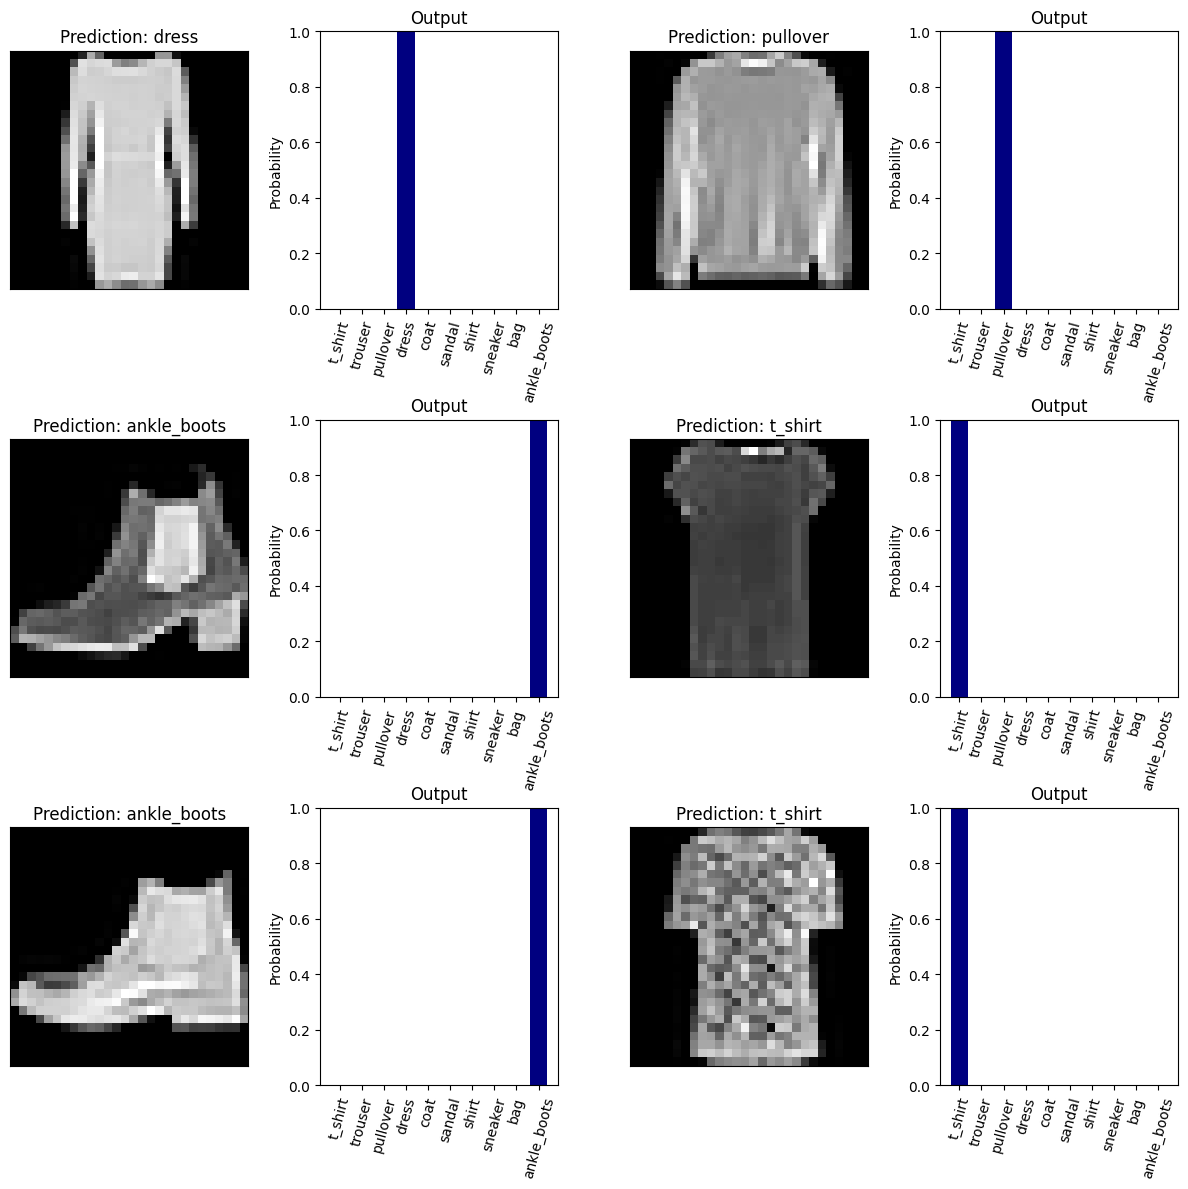

In [27]:
LABEL_NAMES = ['t_shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle_boots']
predictAndPlotAndShowOutput(model_conv, x_test_conv, y_test_conv, label=LABEL_NAMES, convolutional = True)

### Fully Connected Modell erstellen

In [33]:
def createFullyConnectedModel():
    model = tf.keras.models.Sequential()
    model.add(Dense(600, activation='relu', input_shape=(784,),name = "layer_1"))
    model.add(Dense(400, activation='relu',  name = "hidden_layer_1"))
    model.add(Dense(100, activation='relu',  name = "hidden_layer_2"))
    model.add(Dense(10, activation = 'softmax', name = "output_layer"))
    return model
model_fully_connected = createFullyConnectedModel()

In [34]:
x_train_full_connected, y_train_full_connected = load_mnist(kind='train', model_type ='fully_connected')
x_test_full_connected, y_test_full_connected = load_mnist(kind='t10k', model_type ='fully_connected')
x_train_full_connected = np.expand_dims(x_train_full_connected, -1)
x_test_full_connected = np.expand_dims(x_test_full_connected, -1)

### Training des Fully Connected Modells

In [35]:
optimizer = Adam(learning_rate=1e-3)
tf.keras.backend.clear_session()
model_fully_connected.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
train_losses_fully_con, train_accuracies_fully_connected, test_losses_fully_connected, test_accuracies_fully_connected, model_fully_connected = train_and_get_metrics(model_fully_connected, x_train_full_connected[:nr_train_data], y_train_full_connected[:nr_train_data], x_test_full_connected, y_test_full_connected,  epochs=no_epochs,  batch_size=batch_size)


Epoch 1/17
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 545ms/step - accuracy: 0.1444 - loss: 134.1329
Epoch 2/17
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 499ms/step - accuracy: 0.3444 - loss: 93.6374
Epoch 3/17
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - accuracy: 0.4000 - loss: 41.0232
Epoch 4/17
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 0.3444 - loss: 60.7877
Epoch 5/17
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 0.6111 - loss: 26.4014
Epoch 6/17
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.6778 - loss: 14.6526
Epoch 7/17
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 515ms/step - accuracy: 0.5556 - loss: 31.8879
Epoch 8/17
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - accuracy: 0.6556 - loss: 15.7823
Epoch 9/17
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step - accuracy: 0.7444 - loss: 6.3670
Epoch 10/17
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.8667 - loss: 2.5339
Epoch 11/17
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - accuracy: 0.8556 - loss: 3.4024
Epoch 12/17
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step - accuracy: 0.

### Vergleich Convolutional vs Fully connected   

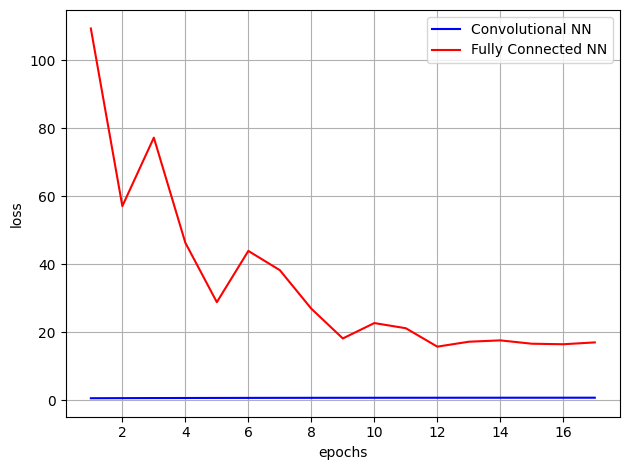

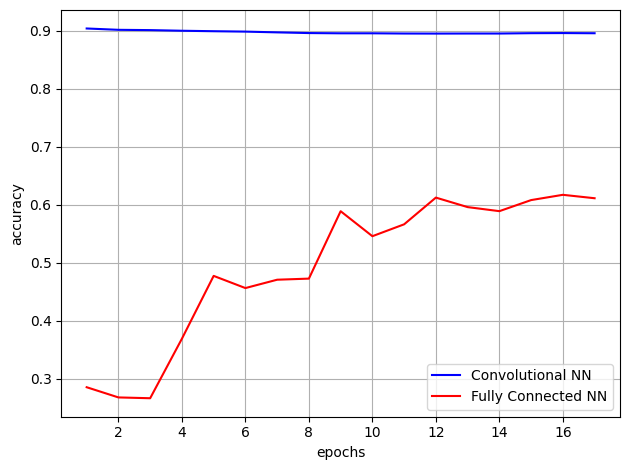

In [40]:
epochs = np.arange(1,no_epochs+1)
plt.plot(epochs, test_losses_conv, label = 'Convolutional NN', color ='blue')
plt.plot(epochs, test_losses_fully_connected, label = 'Fully Connected NN', color ='red')

plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(epochs, test_accuracies_conv, label = 'Convolutional NN', color ='blue')
plt.plot(epochs, test_accuracies_fully_connected, label = 'Fully Connected NN', color ='red')
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

### Feature detection des Convolutional Network

1/1 [==============================] - 0s 62ms/step


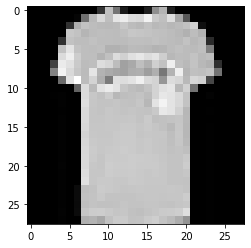

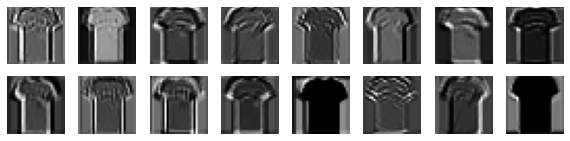

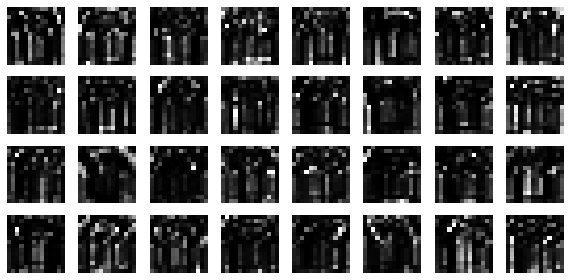

In [ ]:

conv_layer_indices = [0,1]#,2]

# Lade ein Testbeispiel (z.B. x_test[0])
test_example = x_test_conv[19]

# Erstelle ein neues Modell, das die Zwischenergebnisse der ausgewählten Schichten ausgibt
conv_layers = [layer for layer in model_conv.layers if isinstance(layer, tf.keras.layers.Conv2D)]
layer_outputs = [conv_layers[i].output for i in conv_layer_indices]
activation_model = tf.keras.models.Model(inputs=model_conv.input, outputs=layer_outputs)

# Nutze das Testbeispiel, um die Zwischenergebnisse zu erhalten
activations = activation_model.predict(np.expand_dims(test_example, axis=0))
plt.imshow(x_test_conv[19], cmap='gray')
# Plotte die Zwischenergebnisse

for i, activation in enumerate(activations):
    plt.figure(figsize=(10, 10))
    num_filters = activation.shape[3]  # Anzahl der Filter für diesen Convolutional Layer
    num_plots = min(num_filters, 64)  # Höchstens 64 Plots
    for j in range(num_plots):
        plt.subplot(8, 8, j+1)
        plt.imshow(activation[0, :, :, j], cmap='gray')
        plt.axis('off')
    plt.show()

## Plotten der Filter

(5, 5, 1, 16)


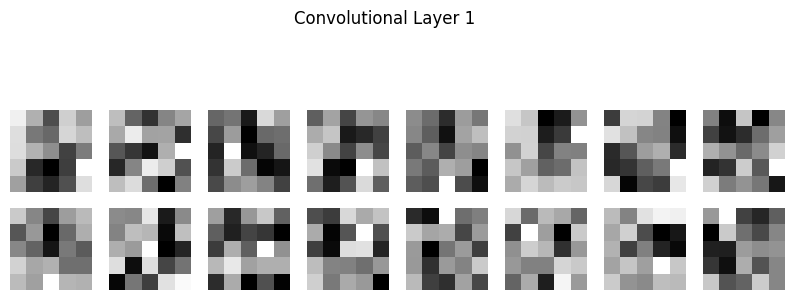

(5, 5, 16, 32)


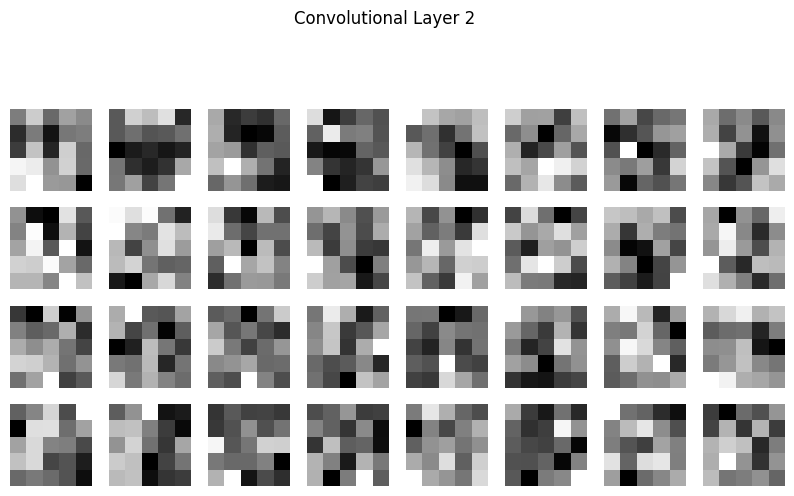

In [42]:
# Gewichtung der Konvolutionalschichten erhalten
conv_layers = [layer for layer in model_conv.layers if isinstance(layer, tf.keras.layers.Conv2D)]

# Filtern für jede Konvolutional-Schicht plotten
for i, layer in enumerate(conv_layers):
    weights = layer.get_weights()[0]
    print(weights.shape)
    
    # Anzahl der Filter in der aktuellen Schicht
    num_filters = weights.shape[3]
    
    # Anzahl der Subplots pro Zeile und Spalte
    n_cols = 8
    
    plt.figure(figsize=(10, 10))
    for j in range(num_filters):
        plt.subplot(8, 8, j+1)
        plt.imshow(weights[:, :, 0, j], cmap='gray')  # Angenommen, Graustufenfilter
        plt.axis('off')
    plt.suptitle(f'Convolutional Layer {i+1}')
    plt.show()

### Vergleich Optimizer Adam vs SGD

In [43]:
optimizer = SGD(learning_rate=1e-3)
model_conv_SGD = createConvModel()
model_conv_SGD.compile(
      optimizer=optimizer,
      loss='sparse_categorical_crossentropy',
      metrics=['sparse_categorical_accuracy'])
train_losses_conv_SGD, train_accuracies_conv_SGD, test_losses_conv_SGD, test_accuracies_conv_SGD, model_conv_SGD = train_and_get_metrics(model_conv_SGD, x_train_conv[:nr_train_data], y_train_conv[:nr_train_data], x_test_conv, y_test_conv,  epochs=no_epochs,  batch_size=batch_size)

Epoch 1/17
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 3s/step - loss: 3.0119 - sparse_categorical_accuracy: 0.0222   
Epoch 2/17
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 2.6999 - sparse_categorical_accuracy: 0.0222      
Epoch 3/17
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 2.4915 - sparse_categorical_accuracy: 0.1333  
Epoch 4/17
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 2.1898 - sparse_categorical_accuracy: 0.2556  
Epoch 5/17
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 1.9986 - sparse_categorical_accuracy: 0.3889  
Epoch 6/17
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 1.9783 - sparse_categorical_accuracy: 0.3778  
Epoch 7/17
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 1.7416 - sparse_categorical_accuracy: 0.4111  
Epoch 8/17
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 1.6625 - sparse_categorical_accuracy: 0.4556  
Epoch 9/17
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 1.5714 - sparse_categorical_accuracy: 0.5222  
Epoch 10/17
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 1.5486 - sparse_categ

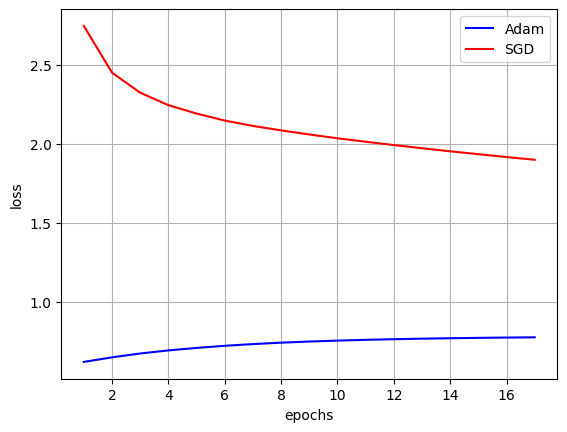

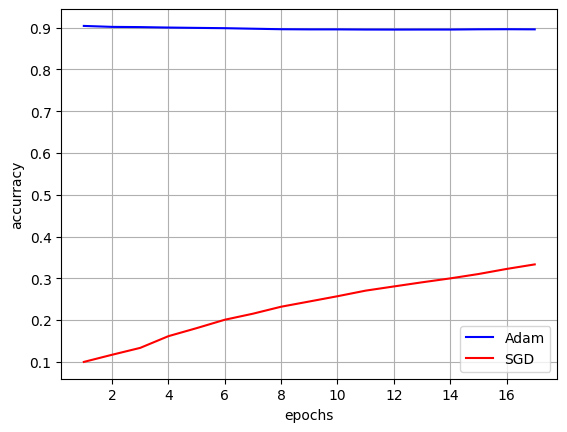

In [44]:
epochs = np.arange(1,no_epochs+1)
plt.plot(epochs,test_losses_conv, label = 'Adam', color = 'blue')
plt.plot(epochs,test_losses_conv_SGD, label = 'SGD', color = 'red')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()
plt.legend()
plt.show()

plt.plot(epochs,test_accuracies_conv, label = 'Adam', color = 'blue')
plt.plot(epochs,test_accuracies_conv_SGD, label = 'SGD', color = 'red')
plt.xlabel("epochs")
plt.ylabel("accurracy")
plt.grid()
plt.legend()
plt.show()

## Handwritten Digits

### Daten Einlesen

In [48]:
def readData(train_size, test_size):
    # Lade den MNIST-Datensatz
    data=np.load("mnist.npz")
    x_train=data['x_train']
    y_train=data['y_train']
    x_test=data['x_test']
    y_test=data['y_test']
    #(x_train, y_train), (x_test, y_test) = mnist.load_data()
    
    # Überprüfe, ob train_size oder test_size nicht größer als die Anzahl der Datensätze ist
    if train_size > len(x_train) :
        print("Fehler: train_size überschreitet Datenmenge von "+str(len(x_train)))
        sys.exit() 
    if test_size > len(x_test) :
        print("Fehler: test_size überschreitet Datenmenge von "+str(len(x_test)))
        sys.exit() 

    # Wähle zufällige Indizes für Trainingsdaten
    train_indices = random.sample(range(len(x_train)), train_size)
    # Wähle zufällige Indizes für Testdaten
    test_indices = random.sample(range(len(x_test)), test_size)
    
    # Extrahiere die ausgewählten Trainingsdaten und Testdaten
    train_data = x_train[train_indices].reshape(train_size, -1) / 255.0
    verify_train_data = y_train[train_indices]
    test_data = x_test[test_indices].reshape(test_size, -1) / 255.0
    verify_test_data = y_test[test_indices]

    return train_data, verify_train_data, test_data, verify_test_data

In [49]:
x_train_digits, y_train_digits, x_test_digits, y_test_digits = readData(60000, 1000)
x_train_digits = x_train_digits.reshape(60000, 28, 28)
x_test_digits = x_test_digits.reshape(1000, 28, 28)
x_train_digits = np.expand_dims(x_train_digits, -1)
x_test_digits = np.expand_dims(x_test_digits, -1)

### Netz Trainieren

In [51]:
tf.keras.backend.clear_session()
model_conv_digits_Adam = createConvModel()
no_epochs=17
batch_size=20
optimizer = Adam(learning_rate=1e-3)
model_conv_digits_Adam.compile(
      optimizer=optimizer,
      loss='sparse_categorical_crossentropy',
      metrics=['sparse_categorical_accuracy'])
train_losses_conv_digits_Adam, train_accuracies_conv_digits_Adam, test_losses_conv_digits_Adam, test_accuracies_conv_digits_Adam, model_conv_digits_Adam = train_and_get_metrics(model_conv_digits_Adam, x_train_digits[:nr_train_data], y_train_digits[:nr_train_data], x_test_digits, y_test_digits,  epochs=no_epochs,  batch_size=batch_size)

Epoch 1/17
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 281ms/step - loss: 3.5925 - sparse_categorical_accuracy: 0.0479 
Epoch 2/17
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - loss: 1.1246 - sparse_categorical_accuracy: 0.6833
Epoch 3/17
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - loss: 0.6398 - sparse_categorical_accuracy: 0.7979
Epoch 4/17
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - loss: 0.1296 - sparse_categorical_accuracy: 0.9833
Epoch 5/17
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - loss: 0.1336 - sparse_categorical_accuracy: 0.9583
Epoch 6/17
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - loss: 0.0790 - sparse_categorical_accuracy: 1.0000
Epoch 7/17
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - loss: 0.0232 - sparse_categorical_accuracy: 1.0000
Epoch 8/17
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - loss: 0.0097 - sparse_categorical_accuracy: 1.0000
Epoch 9/17
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - loss: 0.0045 - sparse_categorical_accuracy: 1.0000
Epoch 10/17
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - loss: 0.0036 - spar

In [52]:
tf.keras.backend.clear_session()
model_conv_digits_SGD = createConvModel()
no_epochs=17
batch_size=20
optimizer = SGD(learning_rate=1e-3)
model_conv_digits_SGD.compile(
      optimizer=optimizer,
      loss='sparse_categorical_crossentropy',
      metrics=['sparse_categorical_accuracy'])
train_losses_conv_digits_SGD, train_accuracies_conv_digits_SGD, test_losses_conv_digits_SGD, test_accuracies_conv_digits_SGD, model_conv_digits_SGD = train_and_get_metrics(model_conv_SGD, x_train_digits[:nr_train_data], y_train_digits[:nr_train_data], x_test_digits, y_test_digits,  epochs=no_epochs,  batch_size=batch_size)

Epoch 1/17
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 304ms/step - loss: 3.0027 - sparse_categorical_accuracy: 0.0375    
Epoch 2/17
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 240ms/step - loss: 2.7729 - sparse_categorical_accuracy: 0.0813
Epoch 3/17
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - loss: 2.4562 - sparse_categorical_accuracy: 0.1479
Epoch 4/17
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - loss: 2.1943 - sparse_categorical_accuracy: 0.2042
Epoch 5/17
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - loss: 2.0720 - sparse_categorical_accuracy: 0.2958
Epoch 6/17
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 231ms/step - loss: 1.9571 - sparse_categorical_accuracy: 0.2688
Epoch 7/17
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 233ms/step - loss: 1.7514 - sparse_categorical_accuracy: 0.4354
Epoch 8/17
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - loss: 1.6927 - sparse_categorical_accuracy: 0.5000
Epoch 9/17
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - loss: 1.5596 - sparse_categorical_accuracy: 0.4875
Epoch 10/17
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - loss: 1.4531 - s

### Plotten des Trainingsprozess

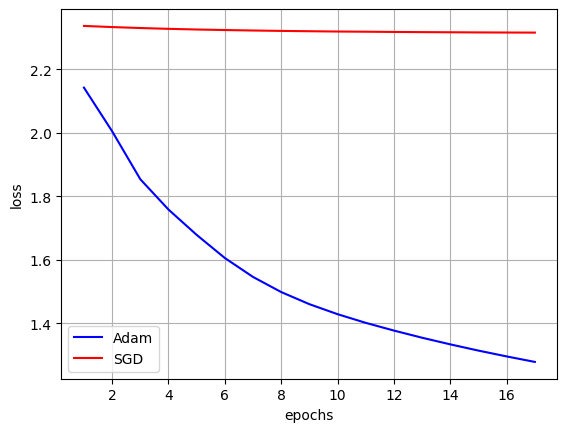

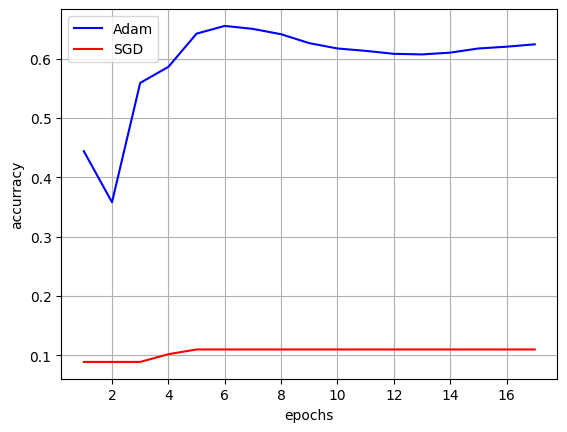

In [53]:
epochs = np.arange(1,no_epochs+1)
plt.plot(epochs,test_losses_conv_digits_Adam, label = 'Adam', color = 'blue')
plt.plot(epochs,test_losses_conv_digits_SGD, label = 'SGD', color = 'red')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()
plt.legend()
plt.show()

plt.plot(epochs,test_accuracies_conv_digits_Adam, label = 'Adam', color = 'blue')
plt.plot(epochs,test_accuracies_conv_digits_SGD, label = 'SGD', color = 'red')
plt.xlabel("epochs")
plt.ylabel("accurracy")
plt.grid()
plt.legend()
plt.show()

### Output der Filter plotten

1/1 [==============================] - 0s 59ms/step


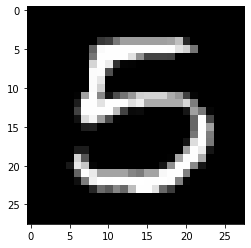

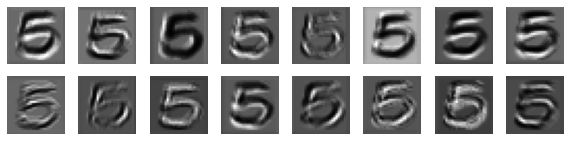

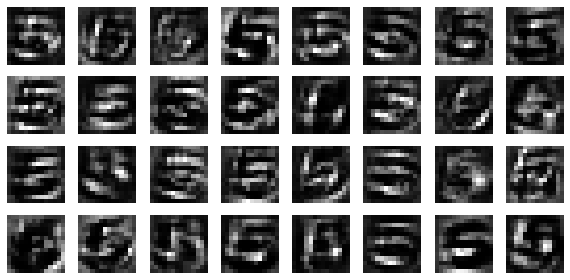

In [ ]:

conv_layer_indices = [0,1]

# Lade ein Testbeispiel (z.B. x_test[0])
test_example = x_test_digits[6]

# Erstelle ein neues Modell, das die Zwischenergebnisse der ausgewählten Schichten ausgibt
conv_layers = [layer for layer in model_conv_digits_Adam.layers if isinstance(layer, tf.keras.layers.Conv2D)]
layer_outputs = [conv_layers[i].output for i in conv_layer_indices]
activation_model = tf.keras.models.Model(inputs=model_conv_digits_Adam.input, outputs=layer_outputs)

# Nutze das Testbeispiel, um die Zwischenergebnisse zu erhalten
activations = activation_model.predict(np.expand_dims(test_example, axis=0))
plt.imshow(x_test_digits[6], cmap='gray')
# Plotte die Zwischenergebnisse

for i, activation in enumerate(activations):
    plt.figure(figsize=(10, 10))
    num_filters = activation.shape[3]  # Anzahl der Filter für diesen Convolutional Layer
    num_plots = min(num_filters, 64)  # Höchstens 64 Plots
    for j in range(num_plots):
        plt.subplot(8, 8, j+1)
        plt.imshow(activation[0, :, :, j], cmap='gray')
        plt.axis('off')
    plt.show()

### Plotten der Filter

(5, 5, 1, 16)


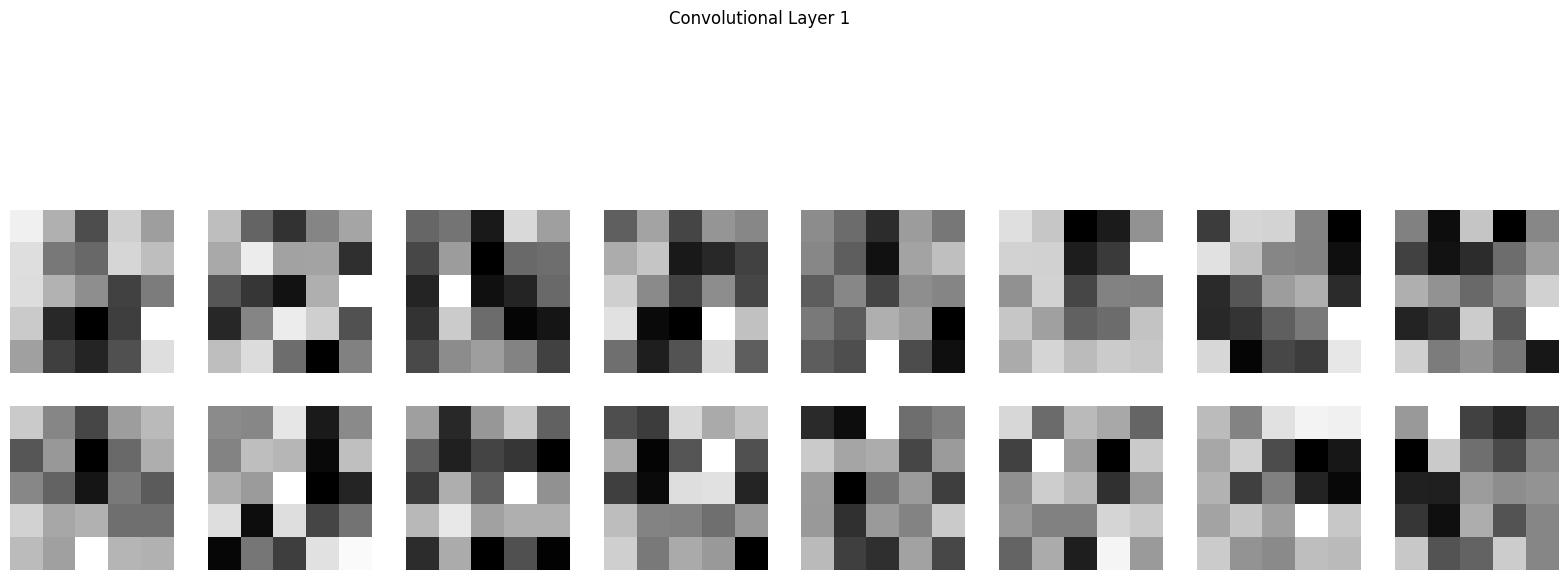

(5, 5, 16, 32)


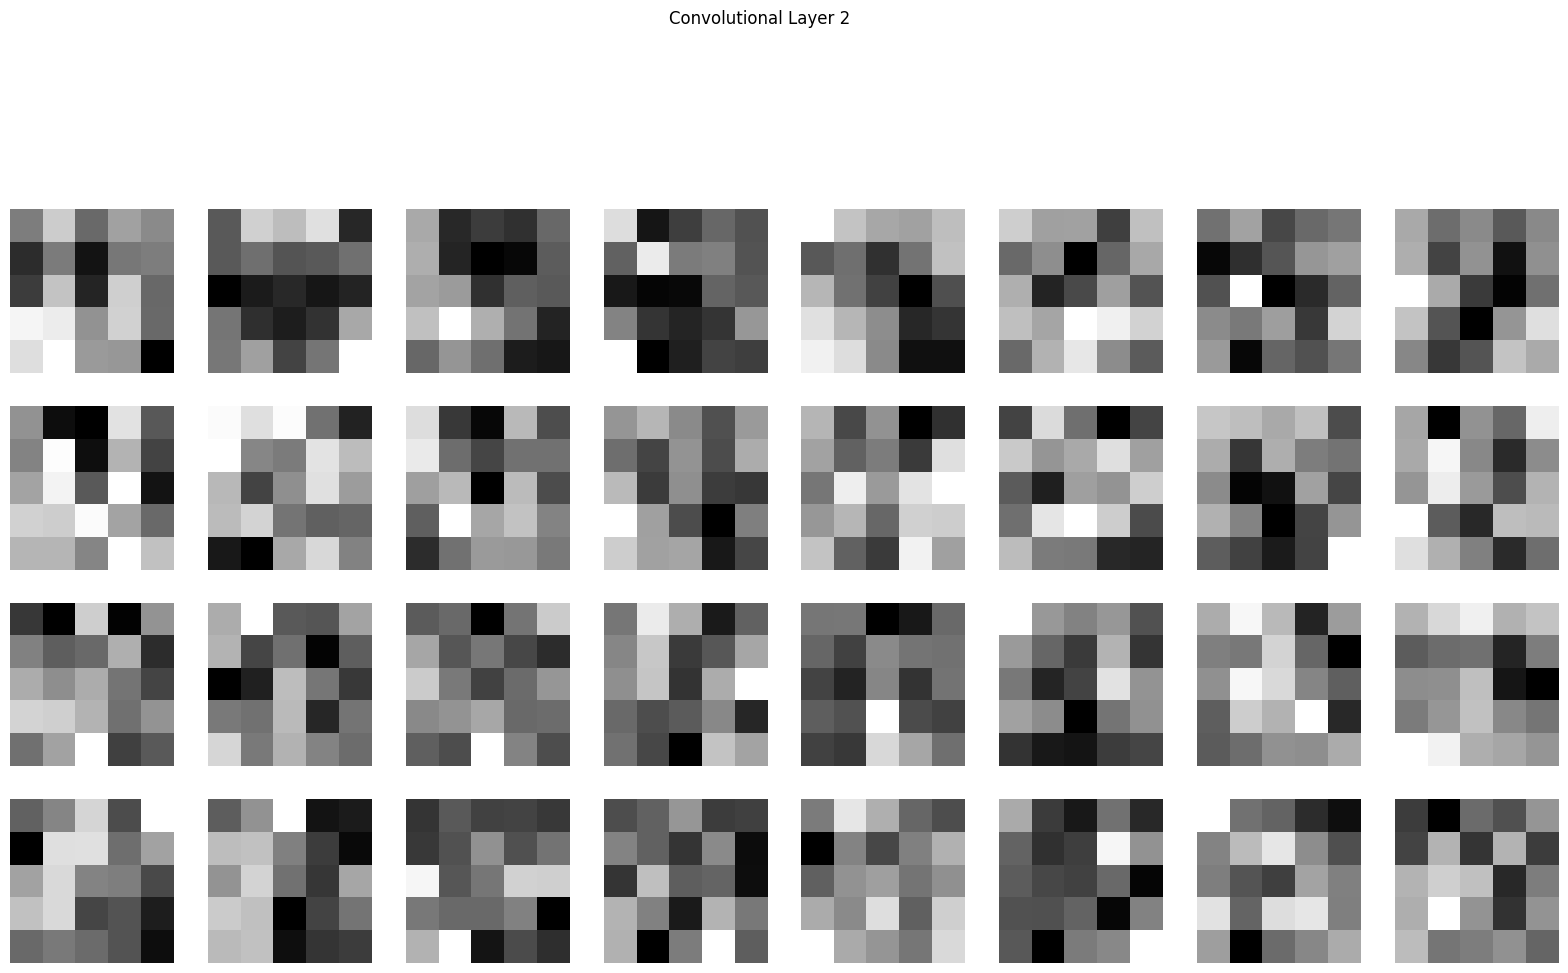

In [56]:
# Gewichtung der Konvolutionalschichten erhalten
conv_layers = [layer for layer in model_conv.layers if isinstance(layer, tf.keras.layers.Conv2D)]

# Filtern für jede Konvolutional-Schicht plotten
for i, layer in enumerate(conv_layers):
    weights = layer.get_weights()[0]
    print(weights.shape)
    
    # Anzahl der Filter in der aktuellen Schicht
    num_filters = weights.shape[3]
    
    # Anzahl der Subplots pro Zeile und Spalte
    n_cols = 8
    
    plt.figure(figsize=(20, 20))
    for j in range(num_filters):
        plt.subplot(8, 8, j+1)
        plt.imshow(weights[:, :, 0, j], cmap='gray')  # Angenommen, Graustufenfilter
        plt.axis('off')
    plt.suptitle(f'Convolutional Layer {i+1}')
    plt.show()